# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [47]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [48]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


## Task 1. Prior predictive checks

In [49]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

Text(0.5, 1.0, 'Height')

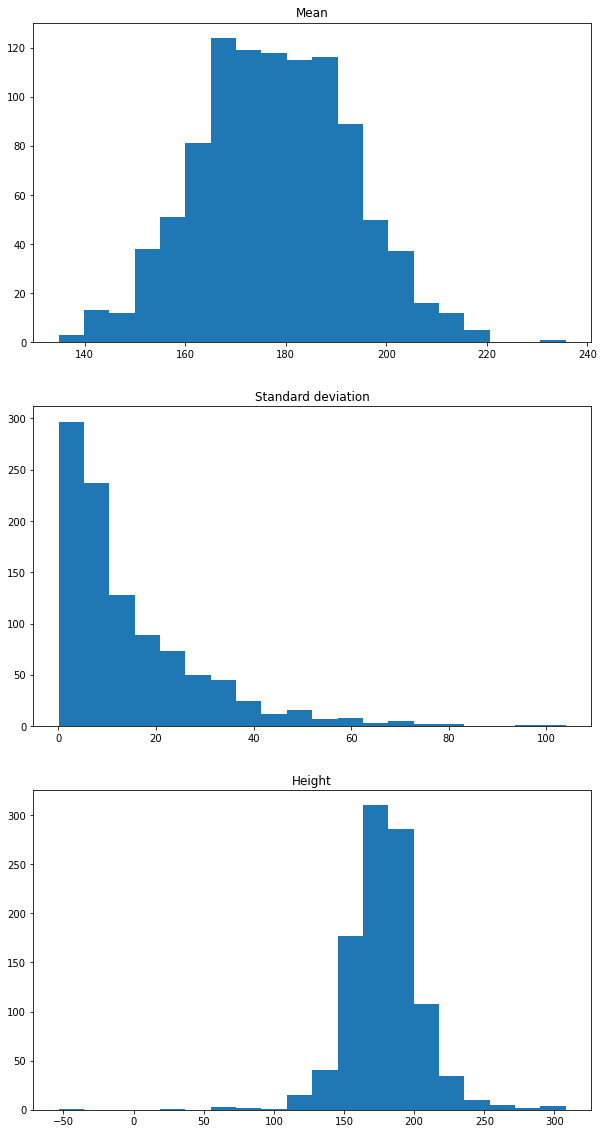

In [50]:
# Ad1
prior_height = sim.draws_pd()
prior_height.head()
fig, axes = plt.subplots(3,1, figsize=(10,20))
axes[0].hist(prior_height["mu"],bins=20, label='Mean')
axes[0].set_title("Mean")

axes[1].hist(prior_height["sigma"],bins=20,label='Std')
axes[1].set_title("Standard deviation")

axes[2].hist(prior_height["height"],bins=20, label='Height')
axes[2].set_title("Height")

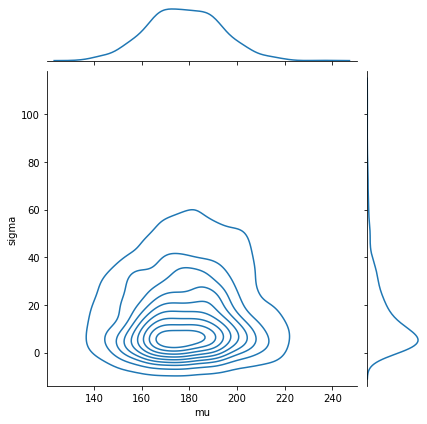

In [51]:
#Ad2
jointplot(prior_height[["mu","sigma"]],x=prior_height["mu"],y=prior_height["sigma"],kind="kde")

#Ad3,4 <br>
Samples are rather consistent with priors. Different priors were tested, sigma was modelled with exponential and normal distribution. Overall I think that using uniform distribution for this case gives best result.

In [52]:
#Ad5
#If by observed data we understand !Kung people height data, then it can be modelled with priors to some extent.
# model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

# R = 352
# sim=model_ppc.sample(iter_sampling=R,
#                      iter_warmup=0,
#                      chains=1,
#                      fixed_param=True,
#                      seed=29042020,refresh=R)
# prior_fit = sim.draws_pd()
# plt.hist(d["height"], bins=20, alpha=0.5, label="Measured data")
# plt.hist(prior_fit["height"], bins=20, alpha=0.5, label="Simulated data")
# plt.legend()

Above code was used as my best attempt at trying to model observed data with priors only. I think its possible to do a better job, but for me this is 'good enough'.<br>
Below picture of my best try.<br>

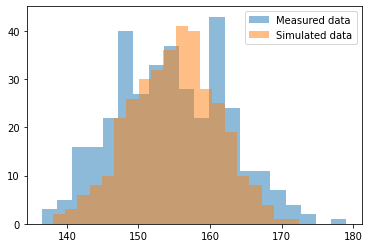

## Task 2. Model fit and evaluation

In [53]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [54]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


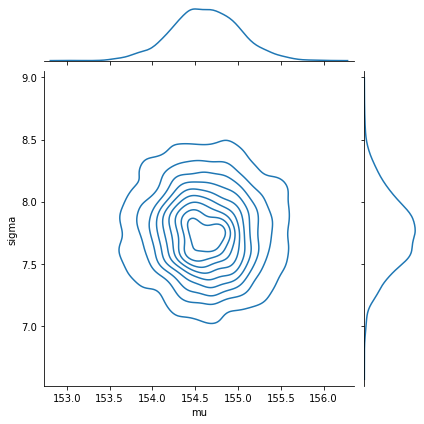

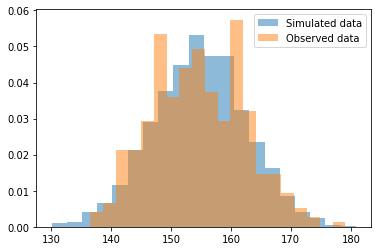

In [55]:
# Ad1
df_fit = fit.draws_pd()
df_fit.head()
jointplot(df_fit[["mu", 'sigma']], x=df_fit["mu"], y=df_fit["sigma"], kind="kde")
plt.show()

# Ad 2
plt.hist(df_fit["height"], density=True, bins=20, alpha=0.5, label="Simulated data")
plt.hist(d["height"], density=True, bins=20, alpha=0.5, label="Observed data")
plt.legend()


Above histograms shows that posterior prediction for our dataset is quite good.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [56]:
d["c_weight"] = d["weight"].mean() - d["weight"]
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


{'N': 50, 'weight': array([-18.00210348, -17.35064354, -16.6991836 , -16.04772366,
       -15.39626373, -14.74480379, -14.09334385, -13.44188391,
       -12.79042397, -12.13896403, -11.48750409, -10.83604415,
       -10.18458421,  -9.53312428,  -8.88166434,  -8.2302044 ,
        -7.57874446,  -6.92728452,  -6.27582458,  -5.62436464,
        -4.9729047 ,  -4.32144477,  -3.66998483,  -3.01852489,
        -2.36706495,  -1.71560501,  -1.06414507,  -0.41268513,
         0.23877481,   0.89023474,   1.54169468,   2.19315462,
         2.84461456,   3.4960745 ,   4.14753444,   4.79899438,
         5.45045432,   6.10191425,   6.75337419,   7.40483413,
         8.05629407,   8.70775401,   9.35921395,  10.01067389,
        10.66213383,  11.31359376,  11.9650537 ,  12.61651364,
        13.26797358,  13.91943352])}


## Task 4. Prior predictive checks
 

In [57]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

(-100.0, 400.0)

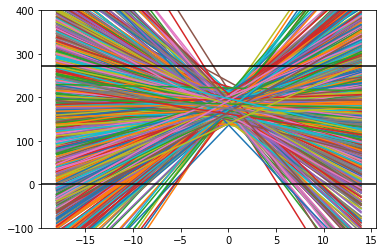

In [58]:
df_sim = sim.draws_pd()
df_sim.describe()

min_weight,max_weight = d.c_weight.min(),d.c_weight.max()
plt.plot([min_weight,max_weight],[df_sim["alpha"]+df_sim["beta"]*min_weight, df_sim["alpha"]+df_sim["beta"]*max_weight])
plt.axhline(y=272, color='k')
plt.axhline(y=0, color='k')
plt.ylim(-100,400)

Black lines are 0 and 272cm height. As we see only small portion of lines are somewhat consistent with those two values.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [59]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [60]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

(-100.0, 400.0)

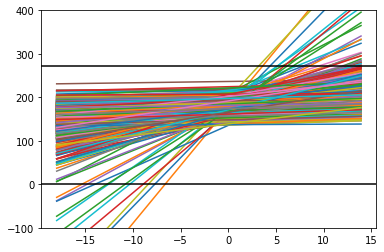

In [61]:
#Ad 1. Using lognormal distribution helped. Now majority of lines stays within bounds
df_sim = sim.draws_pd()

plt.plot([min_weight,max_weight],[df_sim["alpha"]+df_sim["beta"]*min_weight, df_sim["alpha"]+df_sim["beta"]*max_weight])
plt.axhline(y=272, color='k')
plt.axhline(y=0, color='k')
plt.ylim(-100,400)

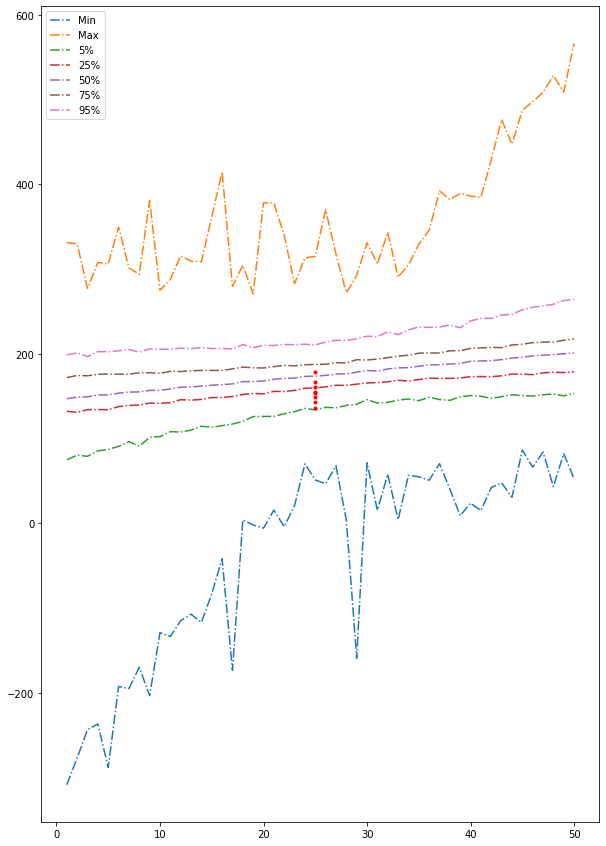

In [62]:
#Ad 2. I assume that we want to plot these values for height, not weight, as we dont simulate latter one
sim_stats = df_sim.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
sim_50 = sim_stats.loc[['mean']].iloc[:,5:]
sim_5 = sim_stats.loc[['5%']].iloc[:,5:]
sim_25 = sim_stats.loc[['25%']].iloc[:,5:]
sim_75 = sim_stats.loc[['75%']].iloc[:,5:]
sim_95 = sim_stats.loc[['95%']].iloc[:,5:]
sim_max = sim_stats.loc[['max']].iloc[:,5:]
sim_min = sim_stats.loc[['min']].iloc[:,5:]

x = np.linspace(1,50)

plt.figure(figsize=(10,15))
plt.plot(x, sim_min.values.T, '-.', label="Min")
plt.plot(x, sim_max.values.T, '-.', label="Max")
plt.plot(x, sim_5.values.T, '-.', label="5%")
plt.plot(x, sim_25.values.T, '-.', label="25%")
plt.plot(x, sim_50.values.T, '-.', label="50%")
plt.plot(x, sim_75.values.T, '-.', label="75%")
plt.plot(x, sim_95.values.T, '-.', label="95%")

#plotting lines for data
data_stats = d.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])["height"].drop(["count","std"])
for stat in data_stats:
    plt.plot(25,stat, 'r.')

plt.legend()
plt.show()

Observed data are possible in prior model, but not likely to be observed. Red dots represent min, max and analogous quantiles for observed data. We see that max value is around model's mean, all quantiles are between 25% and 5% model's quantiles and min of observed data is below 5% quantile of model.

## Task 6. Fitting and evaluating model


In [63]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [70]:
N = 10
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


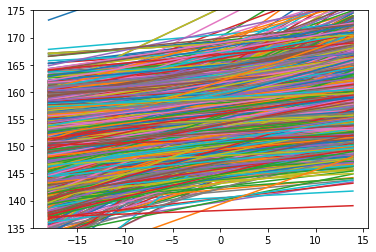

In [71]:
df_fit = fit.draws_pd()

plt.plot([min_weight,max_weight],[df_fit["alpha"]+df_fit["beta"]*min_weight, df_fit["alpha"]+df_fit["beta"]*max_weight])
plt.ylim(135,175)
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 